# Data Exploration - Oticon Audio Explorers

In [22]:
from pathlib2 import Path

from collections import Counter

import numpy as np
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [2]:
# set seed
np.random.seed(42)

# plot style
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

### Load data

In [3]:
DATA_DIR = Path('../data')

# Load npy-files
Xtrainval   = np.load(DATA_DIR / 'raw/npy/training.npy')
ttrainval      = np.load(DATA_DIR / 'raw/npy/training_labels.npy')
Xtest       = np.load(DATA_DIR / 'raw/npy/test.npy')

# Load matlab files
Xtrain_mat  = loadmat(DATA_DIR / 'raw/mat/training.mat', squeeze_me=True)
ttrain_mat  = loadmat(DATA_DIR / 'raw/mat/training_labels.mat', squeeze_me=True)
Xtest_mat   = loadmat(DATA_DIR / 'raw/mat/test.mat', squeeze_me=True)

# Ensure no data difference
assert np.all(Xtrain_mat['data'] == Xtrainval)
assert np.all(ttrain_mat['data'] == ttrainval)
assert np.all(Xtest_mat['data'] == Xtest)

# Clean up
del Xtrain_mat
del ttrain_mat
del Xtest_mat

#### Split dataset

In [4]:
np.random.seed(0)

# Get indexes
train_idxs  = np.random.choice(np.arange(Xtrainval.__len__()), size=int(Xtrainval.__len__() * 0.8), replace=False)
val_idxs    = np.setdiff1d(np.arange(Xtrainval.__len__()), train_idxs)

assert Xtrainval.__len__() == train_idxs.__len__() + val_idxs.__len__()

# Split training set
Xtrain, Xval = Xtrainval[train_idxs, :, :], Xtrainval[val_idxs, :, :]
ttrain, tval = ttrainval[train_idxs], ttrainval[val_idxs]

In [5]:
print(f"Xtrain: {Xtrain.shape}")
print(f"ttrain: {ttrain.shape}")

print(f"\nXval: {Xval.shape}")
print(f"tval: {tval.shape}")

print(f"\nXtest: {Xtest.shape}")

print(f"\nttrain labels in --> {np.unique(ttrain)}")

print(f"\nXtrain (min, max): {Xtrain.min(), Xtrain.max()}")
print(f"Xtest (min, max): {Xtest.min(), Xtest.max()}")

Xtrain: (42312, 32, 96)
ttrain: (42312,)

Xval: (10578, 32, 96)
tval: (10578,)

Xtest: (5347, 32, 96)

ttrain labels in --> [0 1 2 3 4]

Xtrain (min, max): (-80.0, 7.6293945e-06)
Xtest (min, max): (-80.0, 7.6293945e-06)


### Summary

In [6]:
N_train     = len(Xtrain)
N_val       = len(Xval)
N_test      = len(Xtest)
num_classes = len(np.unique(ttrain))

idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}
label2idx   = {v: k for k, v in idx2label.items()}

### ChatGPT background
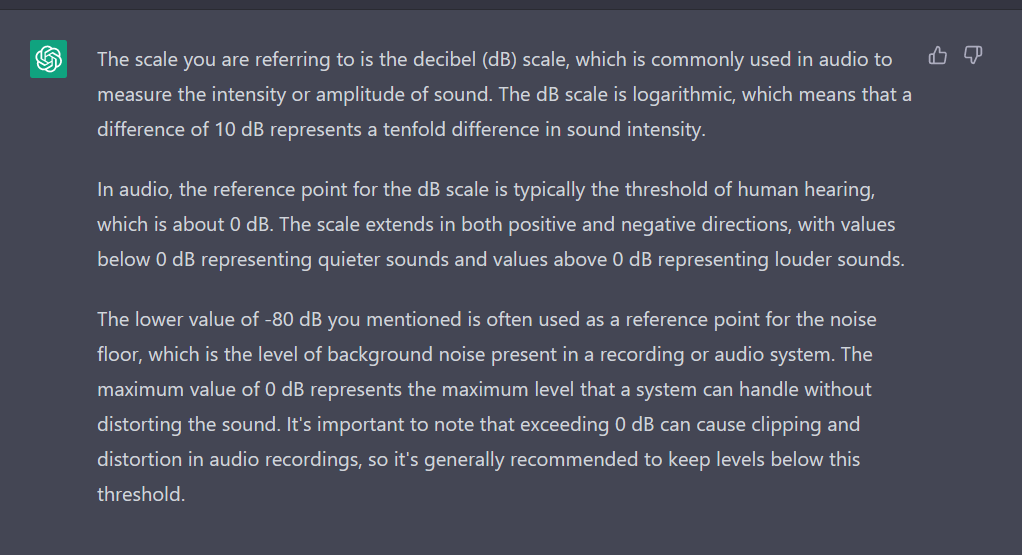

### Visualize label distribution


("Label counts: {'train': {'Music': 21924, 'Other': 11625, 'Human voice': "
 "3857, 'Engine sounds': 3487, 'Alarm': 1419}, 'val': {'Music': 5416, 'Other': "
 "2905, 'Human voice': 966, 'Engine sounds': 925, 'Alarm': 366}}")

("Label frequencies: {'train': {'Music': 0.5181508791832105, 'Other': "
 "0.2747447532614861, 'Human voice': 0.09115617318963887, 'Engine sounds': "
 "0.08241160899981093, 'Alarm': 0.03353658536585366}, 'val': {'Music': "
 "0.5120060502930611, 'Other': 0.2746265834751371, 'Human voice': "
 "0.09132161089052751, 'Engine sounds': 0.08744564189827944, 'Alarm': "
 '0.03460011344299489}}')


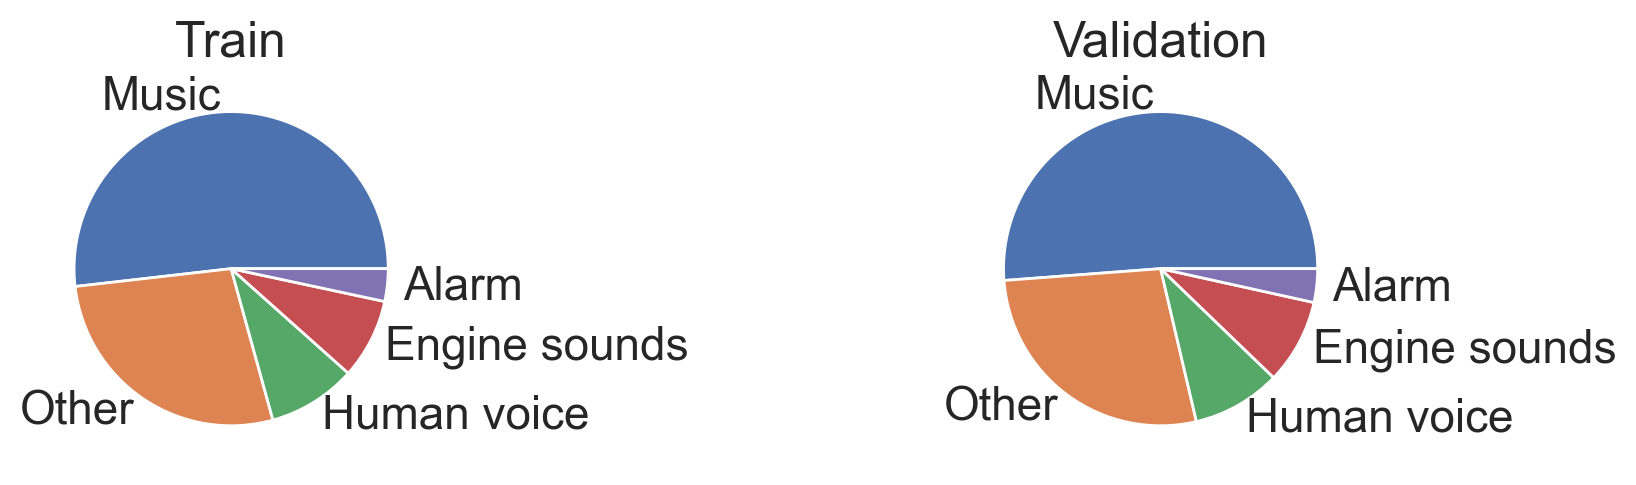

In [9]:
from pprint import pprint

label_dist = {'train': dict(sorted(Counter(ttrain).items(), key=lambda x: -x[1])), 'val': dict(sorted(Counter(tval).items(), key=lambda x: -x[1]))}

label_counts = {dtype: {idx2label[k]: v for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}
label_freqs = {dtype: {idx2label[k]: v / (N_train if dtype == 'train' else N_val) for k, v in dict_.items()} for dtype, dict_ in label_dist.items()}

pprint(f"Label counts: {label_counts}")
print("")
pprint(f"Label frequencies: {label_freqs}")

# Plot pie chart
fig = plt.figure(figsize=(10, 5), dpi=200)
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(x=label_counts['train'].values(), labels=label_counts['train'].keys())
plt.title('Train')

ax1 = plt.subplot2grid((2,2), (0, 1))
plt.pie(x=label_counts['val'].values(), labels=label_counts['val'].keys())
plt.title('Validation')

plt.tight_layout()
plt.show()


### Data balancing


In [10]:
# DO WE NEED THIS?

### Visualize `Xtrain` and `Xtest`

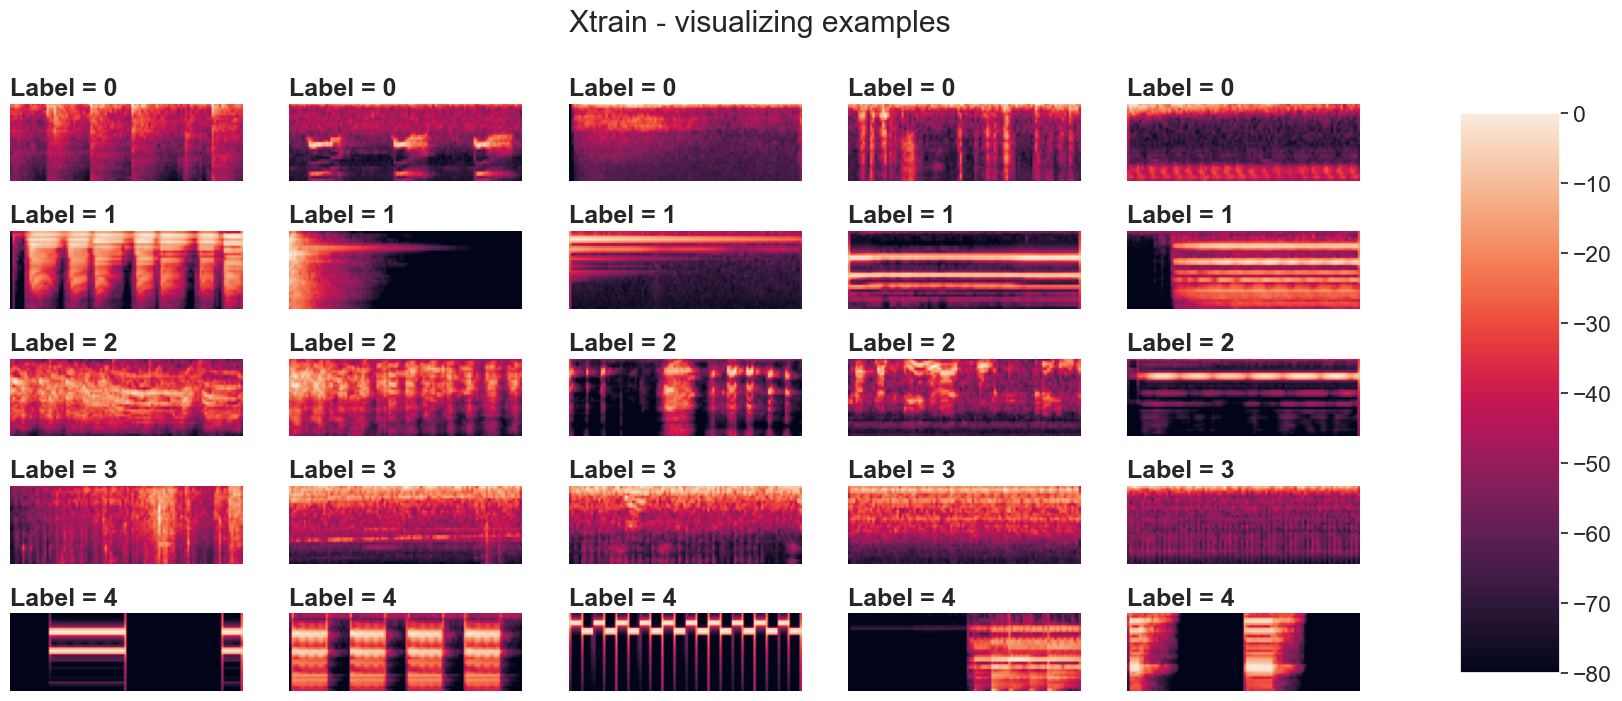

In [11]:
nrows, ncols = 5, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 8))
for i in range(nrows):
    for j in range(ncols):

        # Select class
        Xtrain_class = Xtrain[ttrain == i]
        ttrain_class = ttrain[ttrain == i]
        # Select data point
        idx = np.random.choice(len(Xtrain_class))
        # Show spectrogram
        im = axs[i, j].imshow(Xtrain_class[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = {ttrain_class[idx]}", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtrain - visualizing examples')
plt.show()

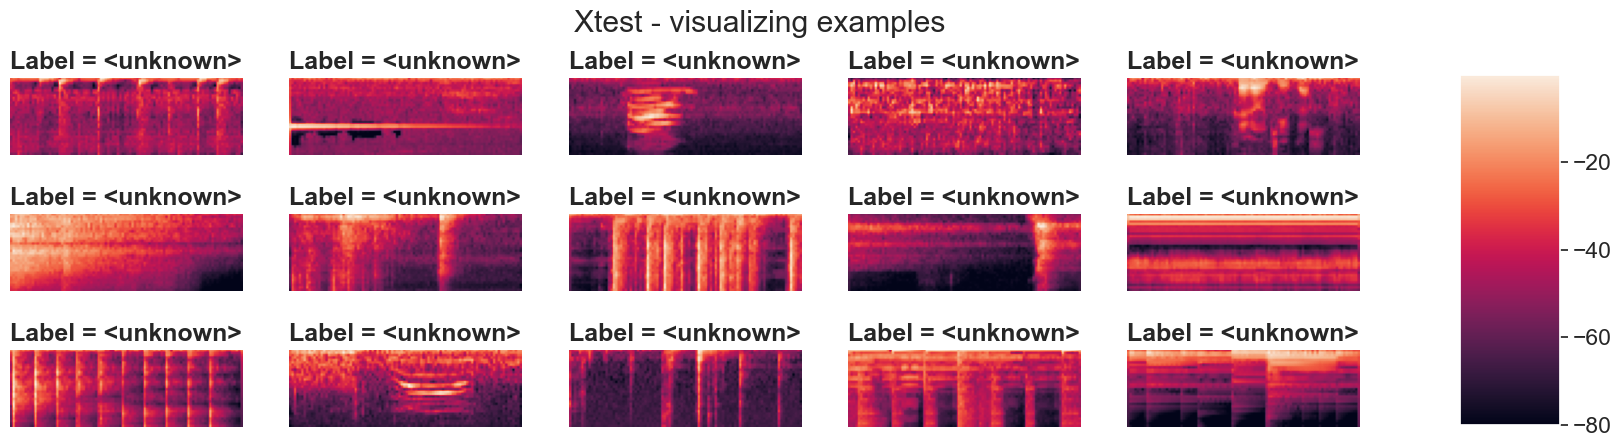

In [12]:
nrows, ncols = 3, 5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(20, 5), squeeze=False)
for i in range(nrows):
    for j in range(ncols):

        # Select data point
        idx = np.random.choice(len(Xtest))
        # Show spectrogram
        im = axs[i, j].imshow(Xtest[idx])
        axs[i, j].axis('off')
        # Add label to title
        axs[i, j].set_title(f"Label = <unknown>", loc='left', weight='bold')

# Add colorbar for dB scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Xtest - visualizing examples')
plt.show()

In [13]:
avg_spectrogram = [Xtrain[ttrain == i].mean(axis=0) for i in range(num_classes)]
std_spectrogram = [Xtrain[ttrain == i].std(axis=0) for i in range(num_classes)]

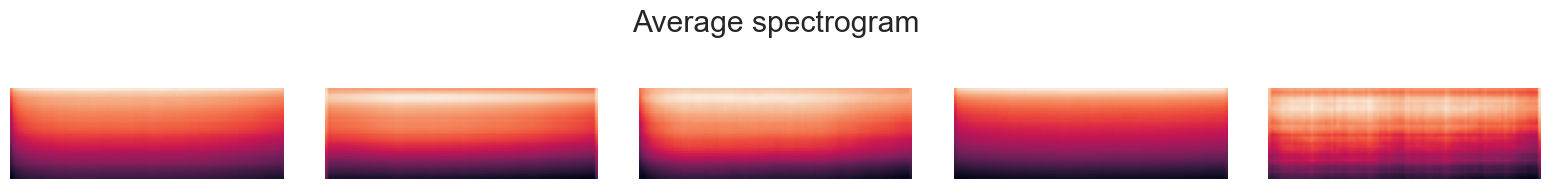

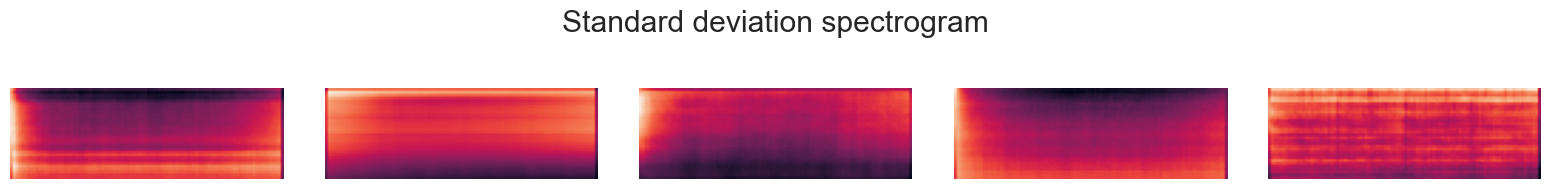

In [14]:
fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True, figsize=(16, 2))
for i in range(num_classes): 
    axs[i].imshow(avg_spectrogram[i])
    axs[i].axis('off')

fig.suptitle('Average spectrogram')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, num_classes, sharex=True, sharey=True, figsize=(16, 2))
for i in range(num_classes): 
    axs[i].imshow(std_spectrogram[i])
    axs[i].axis('off')

fig.suptitle('Standard deviation spectrogram')
plt.tight_layout()
plt.show()

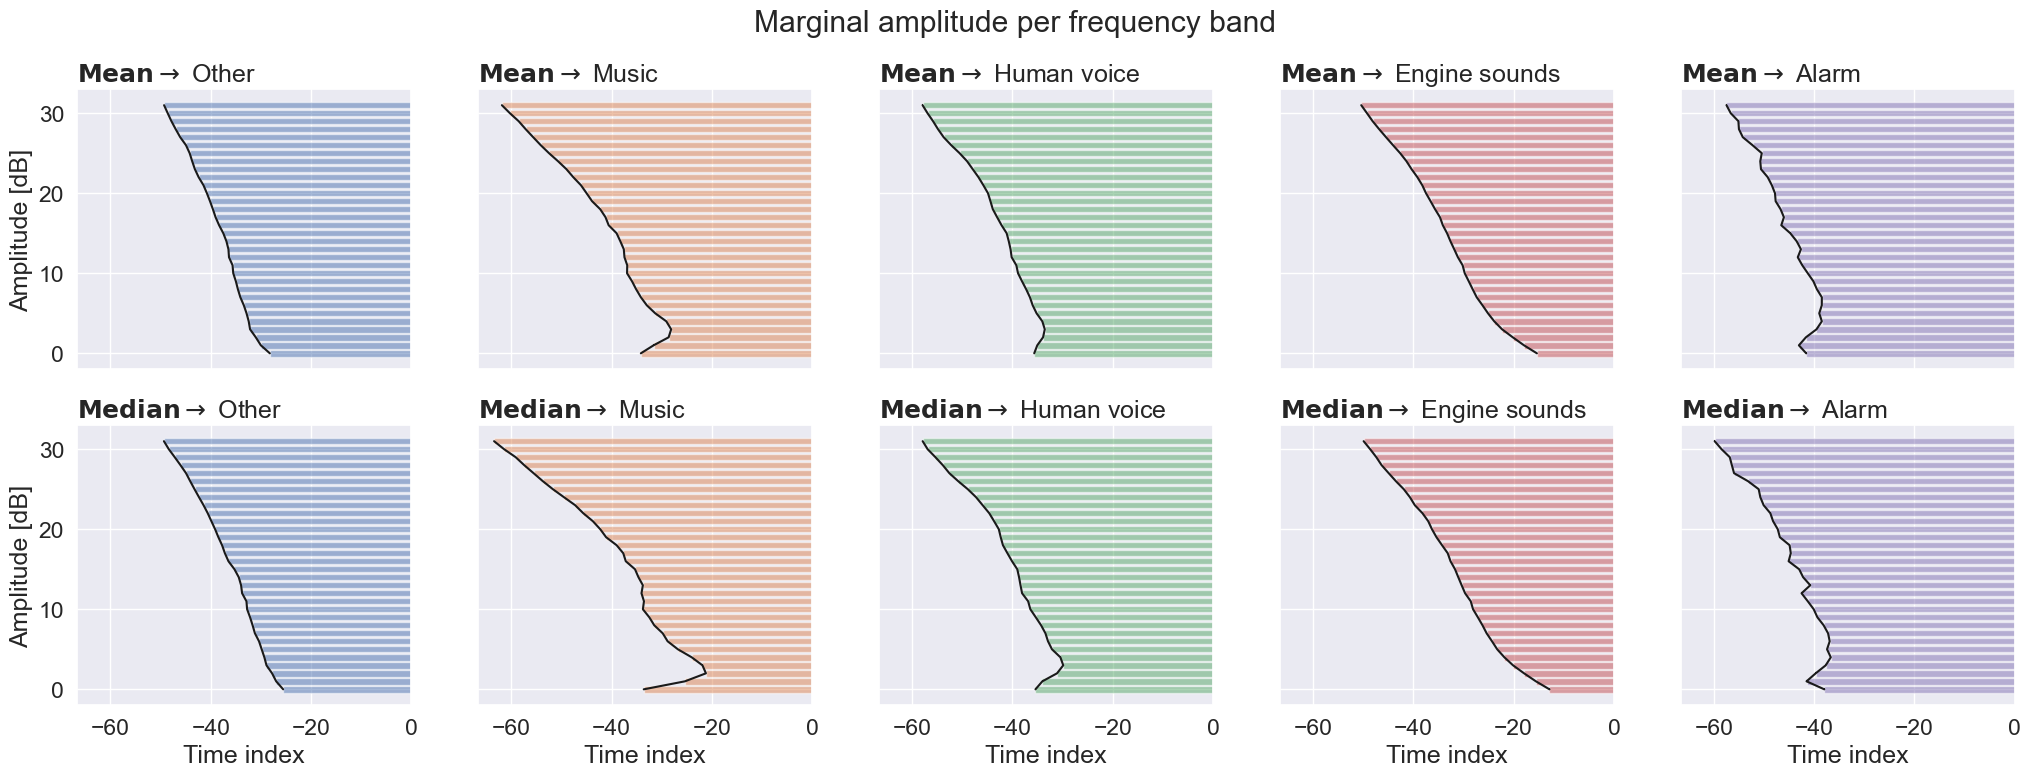

In [15]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25, 8))

for i in range(num_classes):
    # Stack all spectrograms into 1
    Xtrain_class_h = np.hstack(Xtrain[ttrain == i])

    # Plot marginal mean frequency per frequency band
    axs[0, i].barh(np.arange(32), np.mean(Xtrain_class_h, axis=1), alpha=0.5, color=colors[i])
    axs[0, i].errorbar(np.mean(Xtrain_class_h, axis=1), np.arange(32), xerr=np.std(Xtrain_class_h, axis=1) / np.sqrt(Xtrain_class_h.shape[1]), color='k')
    axs[0, i].set_title("$\mathbf{Mean} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    # Plot marginal median frequency per frequency band
    axs[1, i].barh(np.arange(32), np.median(Xtrain_class_h, axis=1), alpha=0.5, color=colors[i])
    axs[1, i].errorbar(np.median(Xtrain_class_h, axis=1), np.arange(32), xerr=np.std(Xtrain_class_h, axis=1) / np.sqrt(Xtrain_class_h.shape[1]), color='k')
    axs[1, i].set_title("$\mathbf{Median} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    axs[1, i].set_xlabel('Time index')

axs[0, 0].set_ylabel('Amplitude [dB]')
axs[1, 0].set_ylabel('Amplitude [dB]')

fig.suptitle("Marginal amplitude per frequency band")
plt.show()

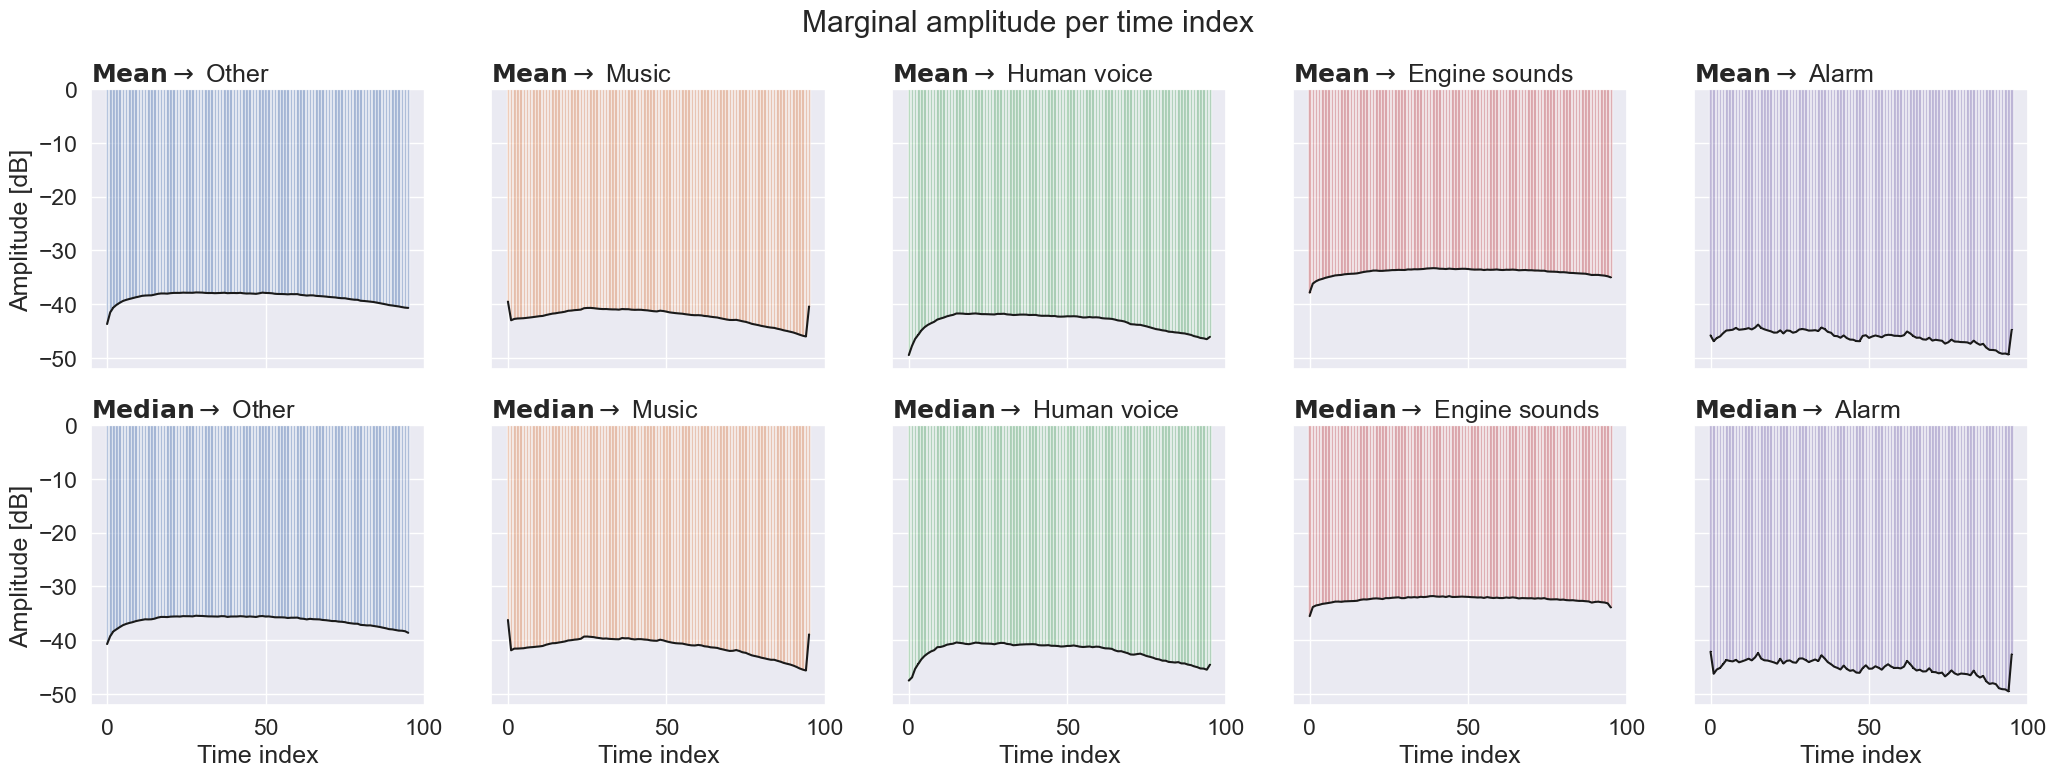

In [16]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(25, 8))

for i in range(num_classes):
    # Stack all spectrograms into 1
    Xtrain_class_v = np.vstack(Xtrain[ttrain == i])

    # Plot marginal mean frequency per time band
    axs[0, i].bar(np.arange(96), np.mean(Xtrain_class_v, axis=0), alpha=0.5, color=colors[i])
    axs[0, i].errorbar(np.arange(96), np.mean(Xtrain_class_v, axis=0), yerr=np.std(Xtrain_class_v, axis=0) / np.sqrt(Xtrain_class_v.shape[0]), color='k')
    axs[0, i].set_title("$\mathbf{Mean} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    # Plot marginal median frequency per time band
    axs[1, i].bar(np.arange(96), np.median(Xtrain_class_v, axis=0), alpha=0.5, color=colors[i])
    axs[1, i].errorbar(np.arange(96), np.median(Xtrain_class_v, axis=0), yerr=np.std(Xtrain_class_v, axis=0) / np.sqrt(Xtrain_class_v.shape[0]), color='k')
    axs[1, i].set_title("$\mathbf{Median} \\rightarrow$ " + f"{idx2label[i]}", loc='left')

    axs[1, i].set_xlabel('Time index')

axs[0, 0].set_ylabel('Amplitude [dB]')
axs[1, 0].set_ylabel('Amplitude [dB]')

fig.suptitle("Marginal amplitude per time index")
plt.show()

### PCA for visualization

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
components = pca.fit_transform(Xtrain.reshape(N_train, -1), ttrain)

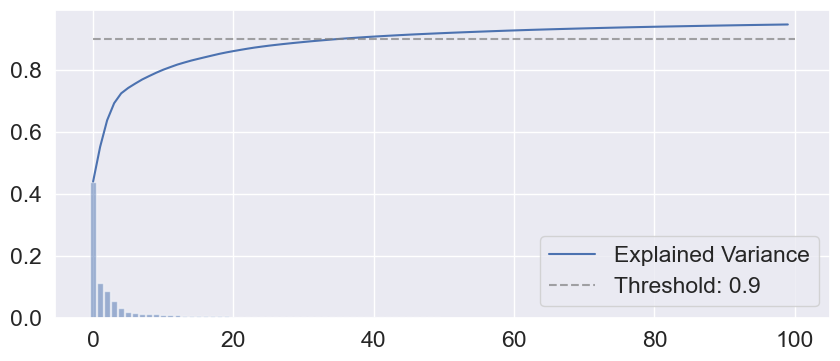

Number of components at threshold of 90%: 35


In [18]:
plt.figure(figsize=(10, 4))
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Explained Variance')
plt.bar(np.arange(100), pca.explained_variance_ratio_, alpha=0.5)
plt.hlines(0.9, 0, 100, ls='--', color='gray', alpha=0.7, label='Threshold: 0.9')

plt.legend()
plt.show()

pca_comp_ = (~(pca.explained_variance_ratio_.cumsum() > 0.9)).sum()
print(f"Number of components at threshold of 90%: {pca_comp_}")

## Linear Softmax classifier - Multinomial Logistic Regression

In [19]:
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# Create design matrices (for full data)
Phi_train       = design_matrix(Xtrain.reshape(N_train, -1))
Phi_val         = design_matrix(Xval.reshape(N_val, -1))
Phi_test        = design_matrix(Xtest.reshape(N_test, -1))

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(ttrain)
tval_enc        = one_hot_encode(tval)

In [20]:
# Get least squares solution
theta_hat_LS = np.linalg.solve(Phi_train.T @ Phi_train, Phi_train.T @ ttrain_enc) 

print("--- LS ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_LS.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_LS, ord=2)}")

# Get ridge solution
lambd_ = 2.
theta_hat_Ridge = np.linalg.solve(Phi_train.T @ Phi_train + lambd_ * np.eye(n_params), Phi_train.T @ ttrain_enc)

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Number of parameters: {theta_hat_Ridge.shape}")
print(f"Magnitude {np.linalg.norm(theta_hat_Ridge, ord=2)}")

--- LS ESTIMATE OBTAINED ---
Number of parameters: (6145, 5)
Magnitude 0.9782804826226029

--- RIDGE ESTIMATE OBTAINED ---
Number of parameters: (6145, 5)
Magnitude 0.9686313697473863


In [21]:
def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    
    # define softmax
    softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

    # get latent function value
    y = Phi @ theta

    # get soft probabilty scores
    prob = softmax(y)

    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob


# Get LS predictions 
ttrain_hat_LS, ttrain_prob_LS       = predict(Phi_train, theta_hat_LS)
tval_hat_LS, tval_prob_LS           = predict(Phi_val, theta_hat_LS)

# Get Ridge predictions 
ttrain_hat_Ridge, ttrain_prob_Ridge = predict(Phi_train, theta_hat_Ridge)
tval_hat_Ridge, tval_prob_Ridge     = predict(Phi_val, theta_hat_Ridge)

#### Evaluation

In [26]:
balanced_accuracy_score(ttrain, ttrain_hat_LS)

0.5177583099142574

In [27]:
print("\n--- LS ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_LS == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_LS == tval).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_LS):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval, tval_hat_LS):.4f}")

print("\n--- RIDGE ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_Ridge == ttrain).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_Ridge == tval).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(ttrain, ttrain_hat_Ridge):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(tval, tval_hat_Ridge):.4f}")


--- LS ESTIMATE OBTAINED ---
Accuracy train: 0.7537
Accuracy validation: 0.6375
Balanced accuracy train: 0.5178
Balanced accuracy validation: 0.3598

--- RIDGE ESTIMATE OBTAINED ---
Accuracy train: 0.7537
Accuracy validation: 0.6378
Balanced accuracy train: 0.5177
Balanced accuracy validation: 0.3599


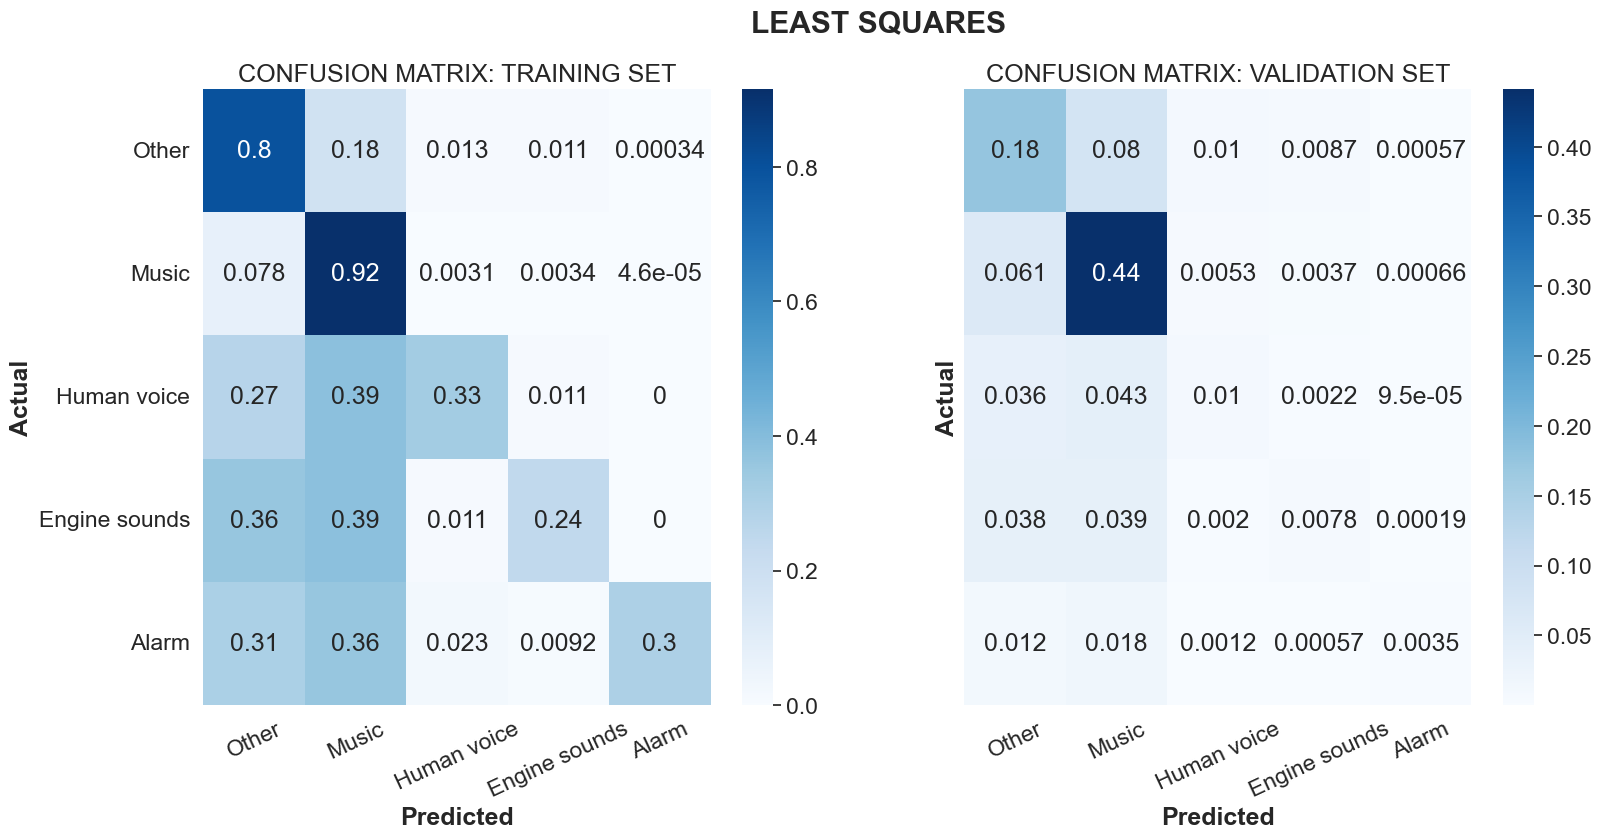

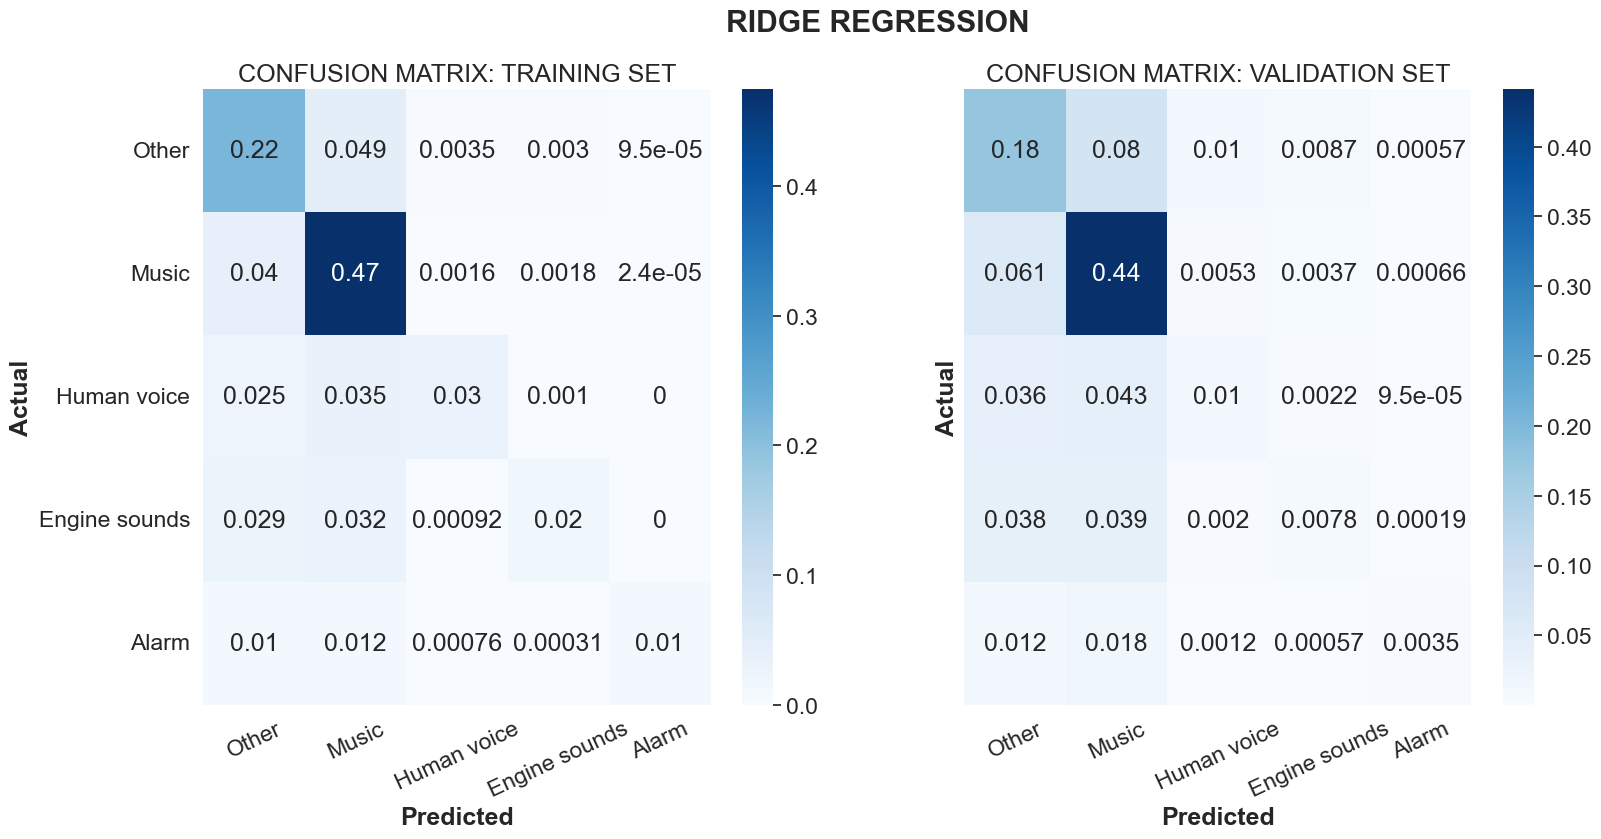

In [29]:
# Compute confusion matrices for least squares predictions
cm_train_LS = confusion_matrix(ttrain, ttrain_hat_LS, normalize='true')
cm_val_LS   = confusion_matrix(tval, tval_hat_LS, normalize='true')

# Compute confusion matrices for ridge predictions
cm_train_Ridge = confusion_matrix(ttrain, ttrain_hat_Ridge, normalize='all')
cm_val_Ridge   = confusion_matrix(tval, tval_hat_Ridge, normalize='all')


for reg_type in ['least squares', 'ridge regression']:
    
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 8))
    for i, (dtype, cm_) in enumerate({
        'training set': cm_train_LS if reg_type == 'least squares' else cm_train_Ridge, 
        'validation set': cm_val_LS if reg_type == 'least_squares' else cm_val_Ridge,
    }.items()):

        # Plot confusion matrix as heatmap
        sns.heatmap(cm_, annot=True, cmap='Blues', ax=axs[i])

        # Set ticks
        ticks = list(zip(*[(i + 0.5, name_) for i, name_ in idx2label.items()]))
        axs[i].set_xticks(ticks[0], ticks[1], rotation=25)
        axs[i].set_yticks(ticks[0], ticks[1], rotation=0)

        # Set labels and title
        axs[i].set_ylabel('Actual', weight='bold')
        axs[i].set_xlabel('Predicted', weight='bold')
        axs[i].set_title(f"Confusion matrix: {dtype}".upper())

    fig.suptitle(f'{reg_type}'.upper(), weight='bold')
    plt.show()